# Tutorial 3: SpaCon for mouse spatial transcriptomics and widefield functional connectivity data

This tutorial demonstrates how to use SpaCon to integrate mouse gene expression and wide‑field calcium imaging data. We first mapped the mouse spatial transcriptomics data onto a cortical atlas and aligned it with the wide‑field calcium imaging data.

The spatial transcriptomics data used here is the MERFISH dataset from the study published in *Nature*: [Molecularly defined and spatially resolved cell atlas of the whole mouse brain](https://www.nature.com/articles/s41586-023-06808-9). The wide‑field calcium imaging data come from: [Diverse and asymmetric patterns of single‑neuron projectome in regulating interhemispheric connectivity](https://www.nature.com/articles/s41467-024-47762-y).

We co‑registered both datasets to the same spatial resolution. The processed data for this tutorial can be downloaded from this [Google Drive link](https://drive.google.com/drive/folders/1lQQQVjXt8lvciuKq_Jkp4LGsR_EQXFAi?usp=sharing).


In [1]:
import spacon
from spacon.utils import build_spatial_graph, build_connection_graph, neighbor_sample, model_train, model_eval, clustering

from spacon.model import SpaCon

import datetime
import os
import scanpy as sc
import matplotlib.pyplot as plt

import torch
import numpy as np
import random

import warnings
warnings.filterwarnings("ignore")
mus = 'mouse_3'
if mus == 'mouse_1':  # coronal
    plot_x, plot_y = 'z', 'y'
    figsize = (5,5)
elif mus == 'mouse_3':   # sagittal
    plot_x, plot_y = 'x', 'y'
    figsize = (11,5)


def set_seed(seed: int):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

**Data preprocessing**

**Load spatial transcriptomics data**

If there are too many genes (for example, more than 5,000), we recommend first screening for highly variable genes using the following method:

```
n_top_genes = 3000
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=n_top_genes)
adata = adata[:, adata.var.highly_variable]
```

In [2]:
adata = sc.read_h5ad('/mnt/Data16Tc/home/haichao/code/SpaCon/ST_FC_cluster/mouse1/data/zxw1_wide_field/zxw1_cortical_map_half_brain_match_wf_conn.h5ad')   # gene expression has been normalize_total and log1p
adata

AnnData object with n_obs × n_vars = 3372 × 1122
    obs: 'x', 'y', 'wf_index'
    uns: 'log1p'
    obsm: 'X_spatial_2d'

**Build spatial graph**

The `build_spatial_graph` function constructs a spatial graph using the three-dimensional spatial coordinates of the spatial transcriptome. The main parameters include:

- `adata`: Spatial transcriptomics data must include the three-dimensional coordinates for each spot (i.e., the slice number and the two-dimensional coordinates within that slice).
- `section_order`: A slice order list where the sequence represents the original arrangement of each slice within the brain. While the slices can be oriented differently, their relative order must be strictly maintained.
- `rad_cutoff`: Neighborhood radius, each spot will have edges added to all other spots within its neighborhood radius.
- `rad_cutoff_Zaxis`: Inter-slice neighborhood radius, each spot will have edges added to spots in adjacent slices that are within this radius.
- `sec_x`: The column name in `adata.obs` that stores the x-coordinate of each spot within its slice.
- `sec_y`: The column name in `adata.obs` that stores the y-coordinate of each spot within its slice.
- `key_section`: Column name in `adata.obs` that stores the slice number (where different numbers indicate different slices).

In [3]:
# calculate the spatial graph for the adata
ST_graph_data, st_adj = build_spatial_graph(adata=adata,  k_cutoff=15, model='KNN',
                                            sec_x='y', sec_y='x', is_3d=False)
ST_graph_data

Data(x=[3372, 1122], edge_index=[2, 53952])

**Load connectivity data and build connection graph**

The `build_connection_graph` function uses connection information to construct a three-dimensional connection graph. The main parameters include:

- `nt_adj`: An n x n two-dimensional matrix, where n is the number of spots in the spatial transcriptomics data, representing the connection strength between spots.
- `threshold`: Filtering threshold, connection strengths below this value will be set to zero.

In [4]:
distance_weight = True
decay_rate = 0.006
neighbor_weight1 = False
neighbor_weight1_percentage = 30

if distance_weight:
    wf_FC_mouse1 = np.load('/mnt/Data16Tc/home/haichao/code/SpaCon/ST_FC_cluster/mouse1/data/zxw1_wide_field/wf_FC_mouse1_fliter_100um.npy')
    coor = np.array(adata.obs[['x', 'y']])
    for i in range(wf_FC_mouse1.shape[0]):
        distances = np.linalg.norm(coor - coor[i], axis=1)
        neighbor = np.percentile(distances, neighbor_weight1_percentage)
        
        weight = 1/(np.exp(-decay_rate * distances))
        # weight = weight/np.max(weight)
        if neighbor_weight1:
            weight[distances < neighbor] = 1
        # weight = weight/np.max(weight)
        # print(weight.max())
        wf_FC_mouse1[i] = np.multiply(wf_FC_mouse1[i], weight)
        # break

In [5]:
def filter_matrix(mat, thr, per):
    n = mat.shape[0]
    k_per_row = int(per * n)  # Calculate the maximum number of elements to retain per row (150)
    filtered_mat = np.zeros_like(mat)  # Initialize the filtered matrix

    for i in range(n):
        row = mat[i, :].copy()  # Copy the current row to avoid modifying the original matrix

        # Step 1: Retain elements greater than 0.7
        mask = row > thr
        valid_indices = np.where(mask)[0]

        if len(valid_indices) == 0:
            continue  # No matching elements, skip

        # Step 2: Sort in descending order by value and select the top k elements
        valid_values = row[valid_indices]
        sorted_indices = np.argsort(-valid_values)  # Indices for descending sort

        k = min(k_per_row, len(sorted_indices))
        selected = sorted_indices[:k]
        selected_indices = valid_indices[selected]

        # Update the filtered matrix
        filtered_mat[i, selected_indices] = row[selected_indices]

    # Optional step: Maintain matrix symmetry
    # filtered_mat = np.maximum(filtered_mat, filtered_mat.T)

    return filtered_mat

thr = 0.8
max_retention_each_row = 0.1
wf_FC_mouse1 = filter_matrix(wf_FC_mouse1, thr=thr, per=max_retention_each_row)
# for i in range(wf_FC_mouse1.shape[0]):
#     wf_FC_mouse1[i,i] = 2

In [6]:
wf_FC_mouse1[wf_FC_mouse1 < thr] = 0
count_after = np.count_nonzero(wf_FC_mouse1)  
proportion_after = count_after/(wf_FC_mouse1.shape[0]*wf_FC_mouse1.shape[1]) 
print(proportion_after)

0.08214357580183748


In [7]:
NT_graph_data = build_connection_graph(adata, wf_FC_mouse1, threshold=thr)
NT_graph_data

Data(x=[3372, 1122], edge_index=[2, 934013])

**Neighbor-based subgraph sampling**

The `neighbor_sample` function performs subgraph sampling from the input spatial graph and connection graph. Its main parameters include:

- `batch_size`: The batch size for model training.
- `train_num_neighbors`: The number of neighbors to sample for each node in each iteration. This parameter is used by the data loader during the model training process.
- `eval_num_neighbors`: The number of neighbors to sample for each node in each iteration. This parameter is used by the data loader during the model evaluation process. If an entry is set to -1, all neighbors will be included.(default:`[-1]`)

The function returns three data loaders: `train_loader`, `evaluate_loader_con`, and `evaluate_loader_spa`. The `train_loader` is used during the **model training process**. Meanwhile, `evaluate_loader_con` and `evaluate_loader_spa` are used for **model evaluation** on the **connection graph** and **spatial graph**, respectively.

In [8]:
train_loader, evaluate_loader_con, evaluate_loader_spa = neighbor_sample(NT_graph_data, ST_graph_data, batch_size=64, train_num_neighbors=[20, 10, 10], num_workers=4)

**Model training**

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# hyper-parameters
num_epoch = 10
lr = 0.0001
weight_decay = 1e-4
hidden_dims = [adata.X.shape[1]] + [256, 128, 32]    
# model
# fusion_method indicates the feature fusion method of the middle layer, you can choose 'add' or 'concat'
model = SpaCon(hidden_dims=hidden_dims, fusion_method='concat').to(device)
# if model_save_path=None, the model will not be saved
results_save_path = f"./results_widefield/{str(datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S'))}/"
os.makedirs(results_save_path, exist_ok=True)

model = model_train(num_epoch, lr, weight_decay, model, train_loader, st_adj, model_save_path=results_save_path, device=device)

epoch:1|10


100%|██████████| 53/53 [00:01<00:00, 26.57it/s]


epoch:2|10


100%|██████████| 53/53 [00:01<00:00, 32.05it/s]


epoch:3|10


100%|██████████| 53/53 [00:01<00:00, 29.43it/s]


epoch:4|10


100%|██████████| 53/53 [00:01<00:00, 30.42it/s]


epoch:5|10


100%|██████████| 53/53 [00:01<00:00, 28.31it/s]


epoch:6|10


100%|██████████| 53/53 [00:01<00:00, 29.57it/s]


epoch:7|10


100%|██████████| 53/53 [00:01<00:00, 30.59it/s]


epoch:8|10


100%|██████████| 53/53 [00:01<00:00, 30.99it/s]


epoch:9|10


100%|██████████| 53/53 [00:01<00:00, 32.25it/s]


epoch:10|10


100%|██████████| 53/53 [00:01<00:00, 31.54it/s]



Training completed! The model parameters have been saved to ./results_widefield/2025_07_24_14_06_20/model_params.pth


**Model evaluation**

The features obtained after model dimensionality reduction, named `feature_spa` and `feature_con`, are stored in the returned `adata.obsm`. These features can be used for subsequent cluster analysis.

In [10]:
adata = model_eval(model, adata, NT_graph_data, ST_graph_data, evaluate_loader_con, evaluate_loader_spa, st_adj, layer_eval=True, device=device)

Evaluating: 100%|██████████| 10116/10116 [00:01<00:00, 8215.90it/s]

The results have been saved in adata.obsm
AnnData object with n_obs × n_vars = 3372 × 1122
    obs: 'x', 'y', 'wf_index'
    uns: 'log1p'
    obsm: 'X_spatial_2d', 'feature_spa', 'feature_con'


**Clustering**

The `clustering` function performs clustering using the louvain algorithm, with the following key parameters:

* `adata`: The AnnData object obtained previously, which contains the clustering features (`feature_spa`, `feature_con`).
* `alpha`: This parameter adjusts the contribution of local spatial information versus global connection information in the clustering results.
    * When `alpha = 1`, the clustering will incorporate more global information.
    * When `alpha = 0`, the clustering will focus more on local information.
    You can set different `alpha` values based on your downstream tasks.
* `adata_save_path`: The path where the results will be saved.
* `cluster_resolution`: The clustering resolution used during the louvain clustering process.

The returned `path` indicates where the clustering results are saved.

In [11]:
adata.obs

x    y  wf_index
0     41   20        22
1     42   20        23
2     43   20        24
3     44   20        25
4     45   20        26
...   ..  ...       ...
3367  25  103      1025
3368  26  103      1047
3369  27  103      1071
3370  28  103      1096
3371  29  103      1122

[3372 rows x 3 columns]

The clustering results have been saved in ./results_widefield/2025_07_24_14_06_20/feature_add_weight1/Clusters_res0.6/
AnnData object with n_obs × n_vars = 3372 × 1122
    obs: 'x', 'y', 'wf_index', 'clusters'
    uns: 'log1p', 'neighbors', 'umap', 'clusters', 'clusters_colors'
    obsm: 'X_spatial_2d', 'feature_spa', 'feature_con', 'feature_add', 'X_umap', 'spatial'
    obsp: 'distances', 'connectivities'


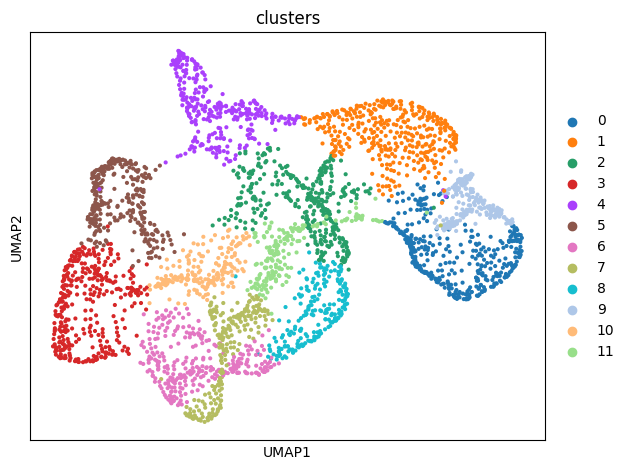

In [14]:
adata, path = clustering(adata, alpha=1, adata_save_path=results_save_path, cluster_resolution=0.6)

[<Axes: title={'center': 'clusters'}, xlabel='spatial1', ylabel='spatial2'>]

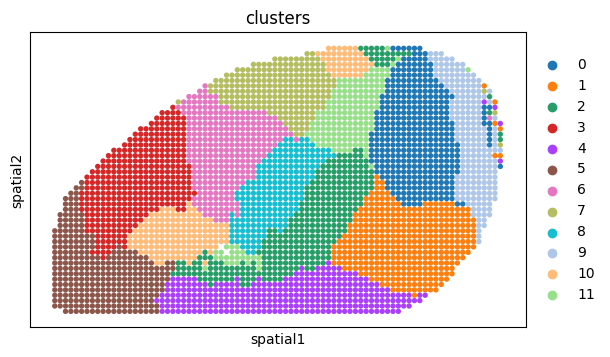

In [15]:
adata.obsm['spatial'] = adata.obs[['y', 'x']].values
sc.pl.spatial(adata, color='clusters', spot_size=1, show=False)

[<Axes: title={'center': 'refine'}, xlabel='spatial1', ylabel='spatial2'>]

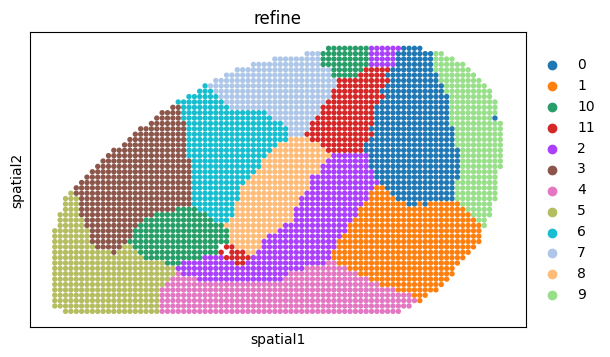

In [17]:
re_label = spacon.utils.refine_label(adata, radius=25, key='clusters')
adata.obs['refine'] = re_label
adata.obs['refine'] = adata.obs['refine'].astype('category')
sc.pl.spatial(adata, color='refine', spot_size=1, show=False)

In [ ]:
for c in adata.obs['clusters'].unique():
    temp_adata = adata[adata.obs['clusters'] == c]
    plt.figure(figsize=(4,6))
    plt.scatter(adata.obs['x'].values, adata.obs['y'].values, c='#d3d3d3', s=10)
    plt.scatter(temp_adata.obs['x'].values, temp_adata.obs['y'].values, c='#FF8C00', s=10)
    # plt.savefig(f'{path}/{c}.png')
    plt.show()